In [1]:
#setup
data_dir='../../Data/Weather'
#!ls $data_dir
state='NY'
m='SNWD'

## Spectral Analysis of Snow Depth in NY state

<img alt="" src="Figures/MeanStdSNWD_NY.png" style="width:800px" />


## Loading libdaries and data
### Load the required libraries

In [2]:
# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
#%pylab inline
import numpy as np

import findspark
findspark.init()

#import sys
#sys.path.append('./lib')

from lib.numpy_pack import packArray,unpackArray

from lib.Eigen_decomp import Eigen_decomp
from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *


from lib.import_modules import import_modules,modules
import_modules(modules)

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.3 	required version>=0.19.2

     numpy as    np 	version=1.13.3 	required version>=1.12.0

   sklearn as    sk 	version=0.19.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=2.2.1 	required version>=2.1.0

ipywidgets as ipywidgets 	version=7.0.0 	required version>=6.0.0

version of ipwidgets= 7.0.0


In [3]:
%aimport lib.decomposer
%aimport lib.Reconstruction_plots
%aimport

Modules to reload:
lib.Reconstruction_plots lib.decomposer

Modules to skip:



In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py','lib/Reconstruction_plots.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)


### Read Statistics File

In [85]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%state
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print('keys from STAT=',measurements)

keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


### Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [86]:
#read data
filename=data_dir+'/%s.parquet'%state
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.Measurement==m)
df.show(5)

+-----------+-----------+----+--------------------+-----+
|    Station|Measurement|Year|              Values|State|
+-----------+-----------+----+--------------------+-----+
|USC00303452|       SNWD|1917|[00 7E 00 7E 00 7...|   NY|
|USC00303452|       SNWD|1920|[00 7E 00 7E 00 7...|   NY|
|USC00303452|       SNWD|1921|[F0 57 60 56 60 5...|   NY|
|USC00303452|       SNWD|1928|[00 7E 00 7E 00 7...|   NY|
|USC00303452|       SNWD|1929|[00 7E 00 7E 00 7...|   NY|
+-----------+-----------+----+--------------------+-----+
only showing top 5 rows



## Compute decomposition for each row, and add columns for coefficients and residuals

Residuals are the remainder left after successive approximations:  
1) Original vector = $\vec{v}$

2) $\vec{r}_0=\vec{v}-\vec{\mu}$

3) $\vec{r}_1=\vec{r}_0-(\vec{v}\cdot \vec{u}_1) \vec{u}_1$

4) $\vec{r}_2=\vec{r}_1-(\vec{v}\cdot \vec{u}_2) \vec{u}_2$

5) $\vec{r}_3=\vec{r}_0-(\vec{v}\cdot \vec{u}_3) \vec{u}_3$  
6) ......

For each reidual $\vec{r}_i$ we compute it's square norm, which we will refer to as **residual norm** :
$$\|\vec{r}_i\|_2^2 = \sum_{j=1}^n (r_{i,j})^2$$

#### A few things we know from linear algebra:

1. The zero'th residual norm is the square distance of $\vec{v}$ from the mean $\vec{\mu}$
1. The $k$'th residual norm is the minimal square between $\vec{v}$ and a point that can be exspressed as
$$ \vec{w}_k = \vec{\mu} + \sum_{i=1}^k c_i \vec{u}_i$$
Where $c_1,\ldots,c_k$ are arbitrary real numbers. We call $\vec{w}_k$ the $k$'th approximation or reconstruction of $\vec{v}$.
1. The residual norms are non-increasing.
1. The residual vector $\vec{r}_n$ is the zero vector. In other words, $\vec{w}_n = \vec{v}$.

`decompose(row)` axtracts the series from the row, computes the square norm of the 
residuals and constructs a new row that is reassembled into a dataframe.

In [87]:
%%time
df2=decompose_dataframe(sqlContext,df,EigVec,Mean)

CPU times: user 12.1 ms, sys: 3.66 ms, total: 15.8 ms
Wall time: 117 ms


In [88]:
%%time
print(df2.count())

14617
CPU times: user 1.28 ms, sys: 2.14 ms, total: 3.42 ms
Wall time: 2.35 s


### Removing years with little snow
In some locations in NY and in some year, there is almost no snow accumulation. We want to treat these separately.

To do so we compare the error of using the average to the error of using a zero vector. We keep only those yearXstation where the mean is a better approximation than the zero Vector

In [84]:
%%time
#filter out vectors for which the mean is a worse approximation than zero.
print('all Rows',df2.count())
df3=df2.filter(df2.res_mean<1)
print('Rows where mean is better approx than zero',df3.count())

all Rows 14617
Rows where mean is better approx than zero 8026
CPU times: user 3.48 ms, sys: 4.64 ms, total: 8.12 ms
Wall time: 4.88 s


In [68]:
%%time
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

CPU times: user 1.8 ms, sys: 1.99 ms, total: 3.8 ms
Wall time: 6 ms


## Plot mean and top eigenvectors

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

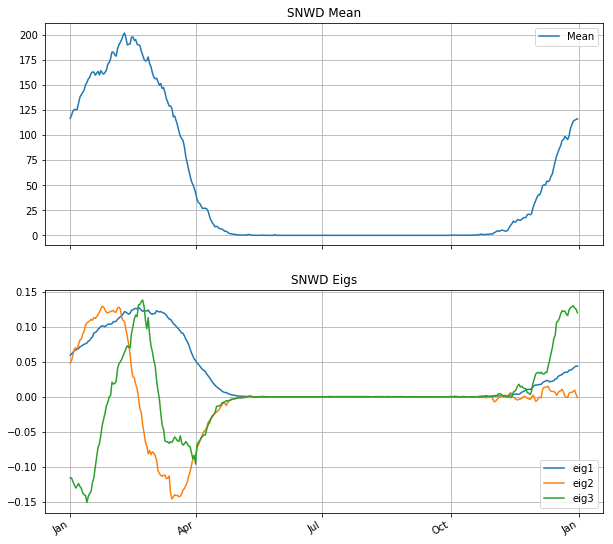

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,10));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
fig.savefig('r_figures/SNWD_mean_eigs')

## plot Percentage of variance explained

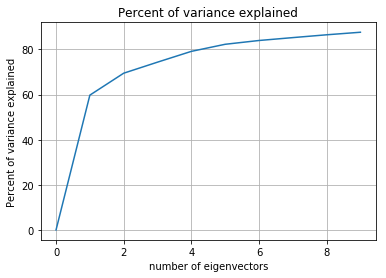

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Exploring the decomposition


### Intuitive analysis

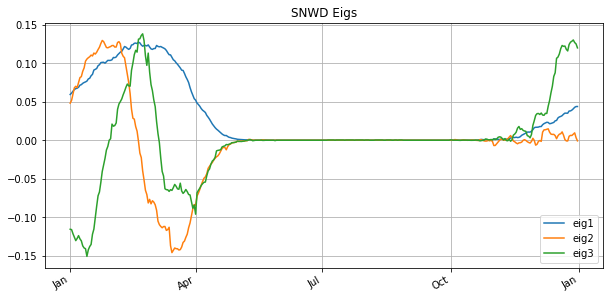

In [75]:
import pylab as plt
fig,axes=plt.subplots(1,1, sharex='col', sharey='row',figsize=(10,5));
k=3
EigVec=np.array(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
#YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes,title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

* **Eig1** is very similar to the Mean --- Indicates heavy/light snow

* **Eig2** is positive january, negative march. Indicates early vs. late season

* **Eig3** is positive Feb, negative Jan, March -- Indicates a short or long season.

### Studying the effect of Coefficient 2

In [76]:
df4=df3.filter(df3.res_2<0.1).sort(df3.coeff_2)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

214


In [78]:
df4.select('res_1','coeff_1','res_2','coeff_2','res_3','coeff_3').show(n=4,truncate=10)

+----------+----------+----------+----------+----------+----------+
|     res_1|   coeff_1|     res_2|   coeff_2|     res_3|   coeff_3|
+----------+----------+----------+----------+----------+----------+
|0.43105...|5732.15...|0.08659...|-4492.9...|0.05808...|-1378.4...|
|0.37526...|5991.27...|0.09770...|-4262.6...|0.09625...|410.614...|
|0.14394...|11306.4...|0.05782...|-3586.1...|0.05751...|214.634...|
|0.34423...|5177.43...|0.09314...|-3226.9...|0.09115...|300.978...|
+----------+----------+----------+----------+----------+----------+
only showing top 4 rows



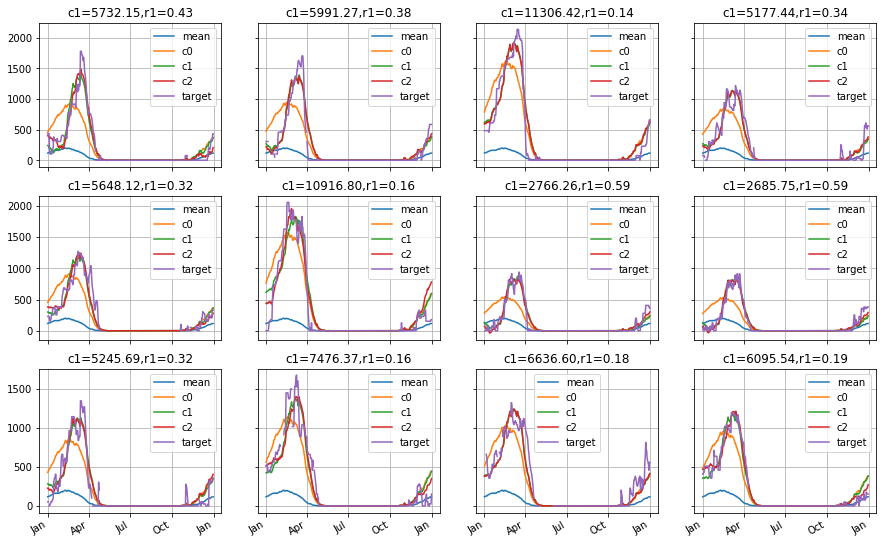

In [79]:
plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('r_figures/SNWD_grid_negative_coeff_2.png')

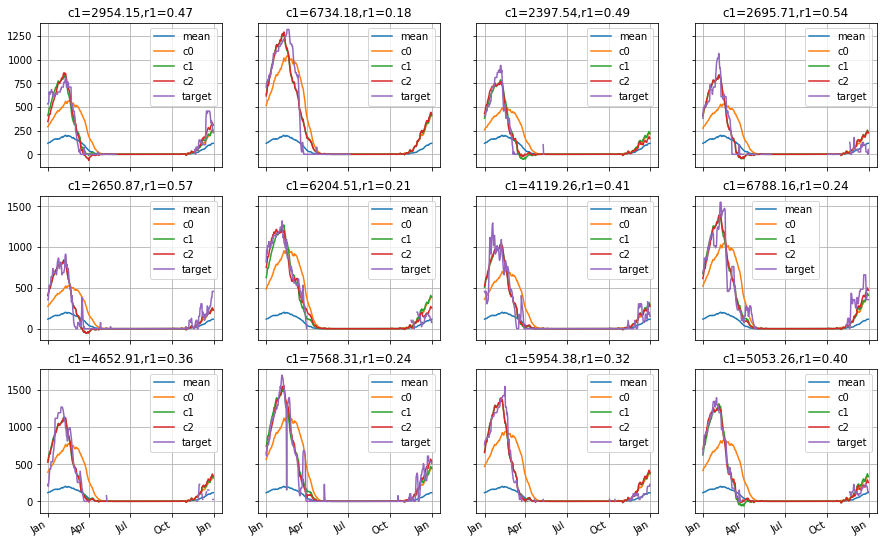

In [80]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)
savefig('r_figures/SNWD_grid_positive_coeff_2.png')

### Studying the effect of Coefficient 3

In [81]:
df4=df3.filter(df3.res_3<0.1).sort(df3.coeff_3)
print(df4.count())
all_rows=df4.collect()
rows=all_rows[:12]

317


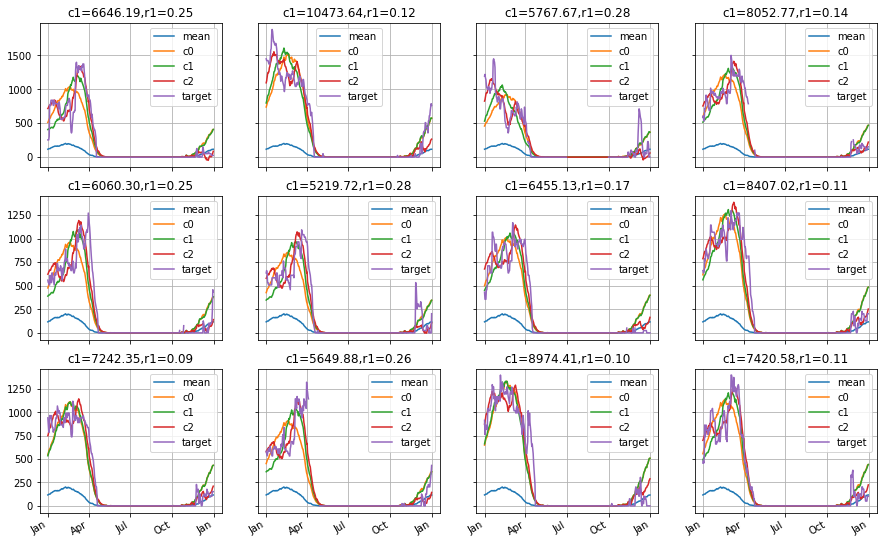

In [82]:

plot_recon_grid(all_rows[:12],Mean,EigVec)
savefig('r_figures/SNWD_grid_negative_coeff_3.png')

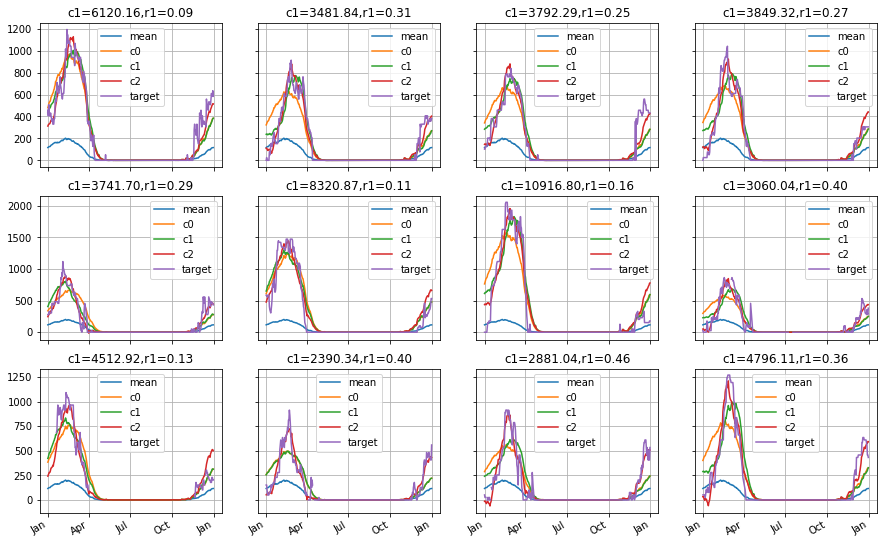

In [83]:
plot_recon_grid(all_rows[-12:],Mean,EigVec)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.783672932683
residual normalized norm  after mean + top eigs: [ 0.12130639  0.10912292  0.05603343]


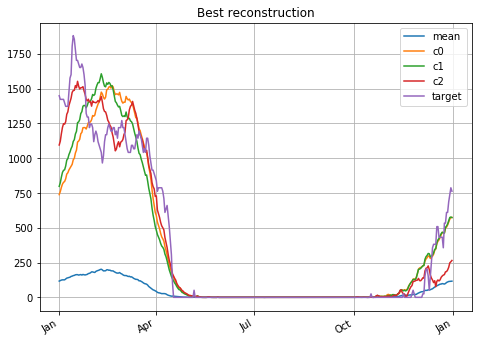

A Jupyter Widget

In [39]:
row=rows[1]
target=np.array(unpackArray(row.Values,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,EigVec)
total_var,residuals,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print('residual normalized norm  after mean:',res[0])
print('residual normalized norm  after mean + top eigs:',res[1:])

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Studying the distribution of the coefficients.

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [124]:
pdf=df3.select(['Station','Year','coeff_1','coeff_2','coeff_3','res_1','res_2','res_3','res_mean','total_var']).toPandas()

In [98]:
#pdf=pdf.set_index('Year')
pdf.head(5)

,Station,Year,coeff_1,coeff_2,coeff_3,res_1,res_2,res_3,res_mean,total_var
0,USC00303452,1917,0.110727,-0.007853,0.111311,0.999633,0.999631,0.999260,0.053397,1250.0
1,USC00303452,1920,15.018348,1.751913,42.619018,0.986912,0.986735,0.886111,0.190265,180325.0
2,USC00303452,1921,-20.039433,-20.160062,38.294924,0.964651,0.929688,0.811218,0.607548,36937.0
3,USC00303452,1941,12.740296,14.982856,2.552944,0.978347,0.948790,0.947939,0.160287,93025.0
4,USC00303452,1950,-13.075101,21.332586,28.776429,0.985631,0.948433,0.883052,0.570773,41209.0


In [99]:
pdf.columns

Index(['Station', 'Year', 'coeff_1', 'coeff_2', 'coeff_3', 'res_1', 'res_2',
       'res_3', 'res_mean', 'total_var'],
      dtype='object')

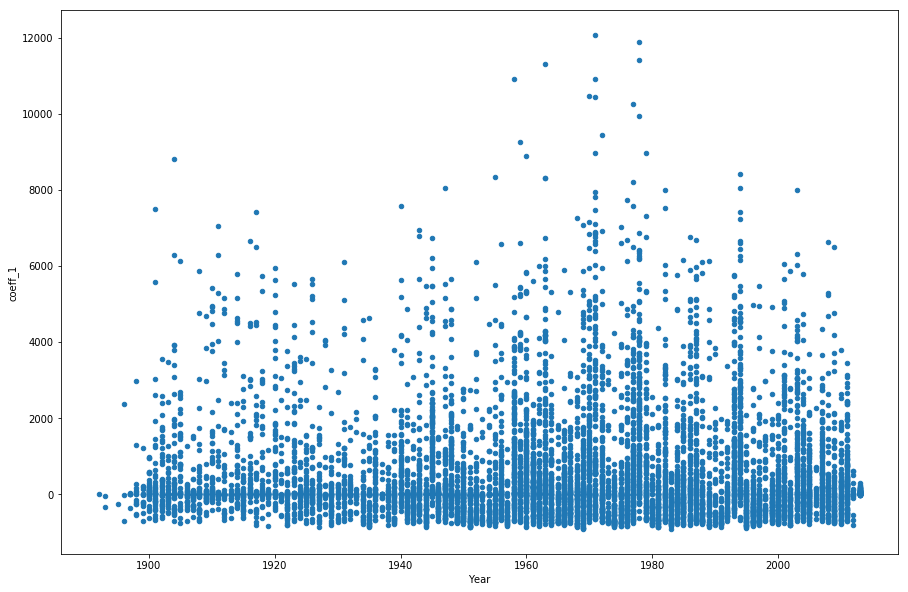

In [103]:
pdf.plot.scatter(x='Year',y='coeff_1',figsize=[15,10])

In [114]:
pdf=pdf.set_index('Year')
pdf.head()

,Station,coeff_1,coeff_2,coeff_3,res_1,res_2,res_3,res_mean,total_var
Year,,,,,,,,,
1917,USC00303452,0.110727,-0.007853,0.111311,0.999633,0.999631,0.999260,0.053397,1250.0
1920,USC00303452,15.018348,1.751913,42.619018,0.986912,0.986735,0.886111,0.190265,180325.0
1921,USC00303452,-20.039433,-20.160062,38.294924,0.964651,0.929688,0.811218,0.607548,36937.0
1941,USC00303452,12.740296,14.982856,2.552944,0.978347,0.948790,0.947939,0.160287,93025.0
1950,USC00303452,-13.075101,21.332586,28.776429,0.985631,0.948433,0.883052,0.570773,41209.0


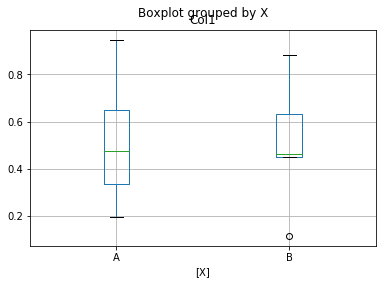

In [123]:
import pandas as pd
df = pd.DataFrame(np.random.rand(10,1), columns=['Col1'] )
df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])
df.boxplot(by='X');

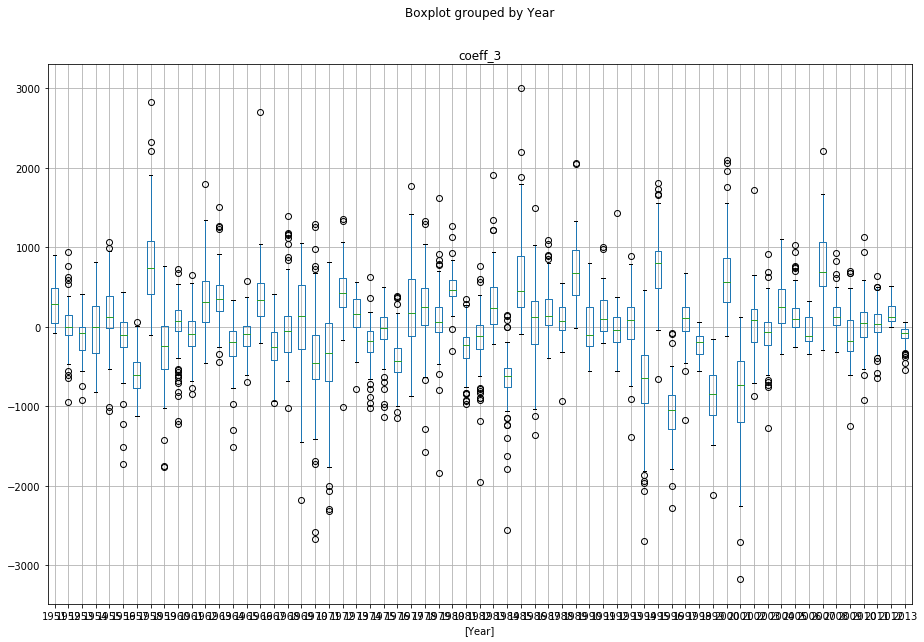

In [130]:
pdf[['Year','coeff_3']][pdf['Year']>1950].boxplot(by='Year',figsize=[15,10])

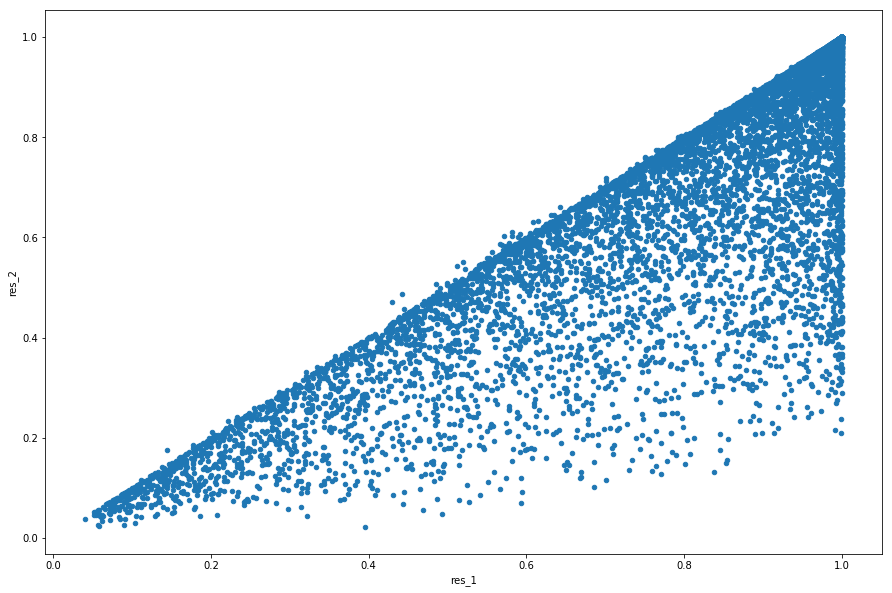

In [135]:
pdf.plot.scatter('res_1','res_2',figsize=[15,10])

In [142]:
grpby=pdf.groupby('Year')['coeff_1']
ratio=grpby.mean()/grpby.std()
np.nanmax(ratio),np.nanmin(ratio)

(1.0562688124818282, -0.94442443271613175)

In [40]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)+1))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

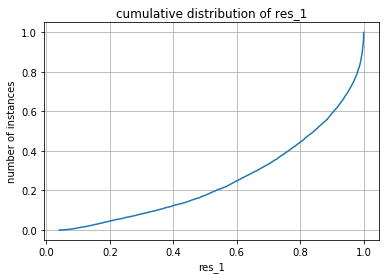

In [49]:
plot_CDF('res_1')

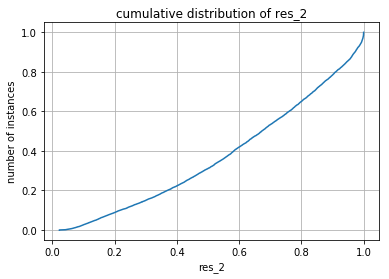

In [50]:
plot_CDF('res_2')

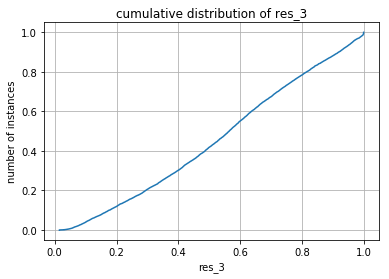

In [51]:
plot_CDF('res_3')

In [ ]:
plot_CDF('coeff_1')
savefig('r_figures/SNWD_coeff_3_CDF.png')

In [ ]:
plot_CDF('coeff_2')
savefig('r_figures/SNWD_coeff_3_CDF.png')

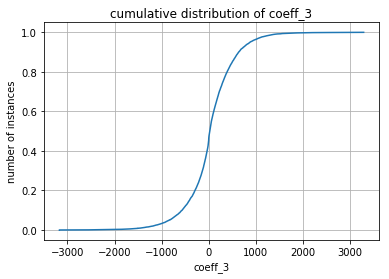

In [48]:
plot_CDF('coeff_3')
savefig('r_figures/SNWD_coeff_3_CDF.png')

In [43]:
filename=data_dir+'/decon_'+state+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [ ]:
!du -sh $data_dir/*.parquet